# Modeling with TensorFlow


In [2]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
  #! pip install tensorflow==2.0.0  # rc causes bugs
  %tensorflow_version 2.x
except:
  IN_COLAB = False

TensorFlow 2.x selected.


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os
import random, math

In [5]:
if IN_COLAB:
    tf.test.gpu_device_name()
    # need to use gpu runtime accelerator!
    mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Data Generators

In [6]:
if IN_COLAB:
    os.chdir(r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/images/'))
!pwd

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images


In [0]:
#move images into train, test, validate folders with subfolders for classes
test_ratio = .15
SPLIT_DATA = False # switch if need to divide out data
if SPLIT_DATA:
    for label in ['sidewalk', 'no_sidewalk']:
        %cd ./$label
        listing = os.popen('ls').read().strip().split(sep='\n')
        random.shuffle(listing) #inplace
        im_count = len(listing)
        test_size=val_size = math.ceil(test_ratio*im_count)
        train_size = im_count - test_size
        subfolders = ['train', 'test'] #train will be used for vdation too
        for subfolder in subfolders:
            new_path=os.path.join(
                os.path.dirname(os.getcwd()), subfolder, label)
            if not os.path.exists(new_path):
                os.makedirs(new_path)
        for item in range(0, train_size):
            moved = listing.pop()
            !mv $moved ../train/$label/$moved
        for item in range(0, test_size):
            moved = listing.pop()
            !mv $moved ../test/$label/$moved
        %cd ..
        !rmdir ./$label

### Parameters for data loading

In [0]:
idg_params={'rescale': 1./255}
batch_size=64
augmentation_params = {'rotation_range': 15,
                        'zoom_range': 0.15,
                         'width_shift_range': 0.2,
                         'height_shift_range': 0.2,
                         'shear_range': 0.15,
                         'fill_mode': 'nearest',
                         'horizontal_flip': True}
datagen_params = {'batch_size': batch_size,
                  'target_size': (224, 224),
                  'color_mode': 'rgb', 
                  'class_mode': 'binary'}

In [0]:
#I will use data in the train folder for both train & validate,
# using built in splitting capabilities
train_vdate_datagen = ImageDataGenerator(
    **idg_params,
    validation_split=0.2)
train_augmented_datagen = ImageDataGenerator(
    **idg_params,
    **augmentation_params,
    validation_split=0.2)
test_datagen = ImageDataGenerator(**idg_params)

In [10]:
# Flow training images using train_datagen generator
vdate_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='validation',
        **datagen_params)
train_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='training',
        **datagen_params)
train_aug_generator = train_augmented_datagen.flow_from_directory(
        directory=r'./train/',
        subset='training',
        **datagen_params)
# note: augmenting val data isn't needed, but lets us use the same datagen
vdate_aug_generator = train_augmented_datagen.flow_from_directory(
        directory=r'./train/',
        subset='validation',
        **datagen_params)
test_generator = test_datagen.flow_from_directory(
        directory=r'./test/',
        **datagen_params)

Found 862 images belonging to 2 classes.
Found 3454 images belonging to 2 classes.
Found 3454 images belonging to 2 classes.
Found 862 images belonging to 2 classes.
Found 1635 images belonging to 2 classes.


### Parameters for Modeling

In [0]:
n_epochs = 35
learning_rate = 0.000_5
loss = 'binary_crossentropy'

### Get Class Weights

In [12]:
imagecount = {}
sidewalk_image_count = ! cd ./train/sidewalk/ && ls | wc -l
no_sidewalk_image_count = ! cd ./train/no_sidewalk/ && ls | wc -l
imagecount['sidewalk'] = int(sidewalk_image_count.nlstr)
imagecount['no_sidewalk'] = int(no_sidewalk_image_count.nlstr)
imagecount['total'] = imagecount['sidewalk'] + imagecount['no_sidewalk']
print(imagecount)

{'sidewalk': 3342, 'no_sidewalk': 974, 'total': 4316}


In [13]:
#adjust weights to equivalent between classes
class_weight = {}
class_weight['sidewalk'] = (
    .5 / imagecount['sidewalk']) * imagecount['total']
class_weight['no_sidewalk'] = (
    .5 / imagecount['no_sidewalk']) * imagecount['total']
class_weight

{'no_sidewalk': 2.2156057494866532, 'sidewalk': 0.6457211250748055}

In [14]:
class_id = train_generator.class_indices
#class ids are floats ## OR NOT depends on tf version??!
class_id = {key: int(value) for (key,value) in class_id.items()}
class_weight[class_id['sidewalk']] = class_weight.pop('sidewalk')
class_weight[class_id['no_sidewalk']] = class_weight.pop('no_sidewalk')
class_weight

{0: 2.2156057494866532, 1: 0.6457211250748055}

In [15]:
#generator based caluculations
input_shape = train_generator.next()[0].shape[1:]
total_train_samples = train_generator.n
total_vdate_samples = vdate_generator.n
input_shape

(224, 224, 3)

### Setup Metrics and Visualizations

Use Matthew Correlation Coefficient to take into account all four quadrants of confusion matrix, while remaining robust to imbalanced classes. The dataset we are working with has minor imbalance.

In [0]:
# if y_pred > threshold we predict true. 
# Sometimes we set this to something different to 0.5 if we have unbalanced categories
threshold = 0.5  
def matthews_correlation(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def history_plotter(history, n_epochs=n_epochs, plot_validation=True): 
    '''plot the training loss and accuracy
    plot_validation exists because valdation not working in model
    '''
    n_epochs_range = np.arange(0, n_epochs)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                                  figsize=(15,7))
    ax1.plot(n_epochs_range, history.history["loss"], label="Loss")
    ax1.plot(n_epochs_range, history.history["accuracy"], label="Accuracy")
    ax1.plot(n_epochs_range, history.history['auc'], label='Area Under ROC')
    ax1.plot(n_epochs_range, history.history['matthews_correlation'], label="Matthews Coef")
    if plot_validation:
        ax2.plot(n_epochs_range, history.history["val_loss"], label="loss")
        ax2.plot(n_epochs_range, history.history["val_accuracy"], label="Accuracy")
        ax2.plot(n_epochs_range, history.history["val_auc"], label="Area Under ROC")
        ax2.plot(n_epochs_range, history.history["val_matthews_correlation"], label="Matthews Coef")
    
    ax1.set_title("Training Metrics")
    ax2.set_title("Validation Metrics")
    ax1.set_xlabel("Epoch"); ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Metric Score")
    ax1.legend(loc='upper left'); ax2.legend(loc='upper left')

### Convolutional Model

In [0]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      matthews_correlation]

In [19]:
conv_model = tf.keras.models.Sequential()
conv_model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_initializer='he_uniform'))
conv_model.add(MaxPooling2D(pool_size=(3, 3)))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(16, activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=.0005), 
              metrics=METRICS)
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 64)        2

In [0]:
if IN_COLAB:
    save_model_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/conv_classif_weights.hdf5'
    save_model_aug_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/conv_aug_classif_weights.hdf5'

else:
    save_model_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/conv_classif_weights.hdf5')
    save_model_aug_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/conv_aug_classif_weights.hdf5')

checkp_params = dict(monitor='val_matthews_correlation', 
                         save_best_only=True, 
                         mode='max',
                         verbose=1)

cb = ModelCheckpoint(filepath=save_model_path, **checkp_params)
cb_aug = ModelCheckpoint(filepath=save_model_aug_path, **checkp_params)
fit_params=dict(steps_per_epoch=int(total_train_samples/batch_size),
                validation_steps=int(total_vdate_samples/batch_size),  
                epochs=n_epochs,
                verbose=1,
                use_multiprocessing=False,
                class_weight=class_weight,
                )

In [26]:
conv_history = conv_model.fit(
        train_generator, 
        validation_data=vdate_generator,
        callbacks=[cb],
        **fit_params)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 13 steps
Epoch 1/25
52/53 [============================>.] - ETA: 0s - loss: 0.7002 - accuracy: 0.6248 - auc: 0.7013 - matthews_correlation: 0.2457
Epoch 00001: val_matthews_correlation did not improve from -inf
53/53 [==============================] - 31s 579ms/step - loss: 0.6962 - accuracy: 0.6271 - auc: 0.7050 - matthews_correlation: 0.2514 - val_loss: 1.5204 - val_accuracy: 0.2272 - val_auc: 0.7134 - val_matthews_correlation: nan
Epoch 2/25
52/53 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.6687 - auc: 0.7398 - matthews_correlation: 0.3061
Epoch 00002: val_matthews_correlation did not improve from -inf
53/53 [==============================] - 29s 555ms/step - loss: 0.6404 - accuracy: 0.6699 - auc: 0.7420 - matthews_correlation: 0.3098 - val_loss: 2.2204 - val_accuracy: 0.2272 - val_auc: 0.7029 - val_matthews_correlation: nan
Epoch 3/25
52/53 [============================>.

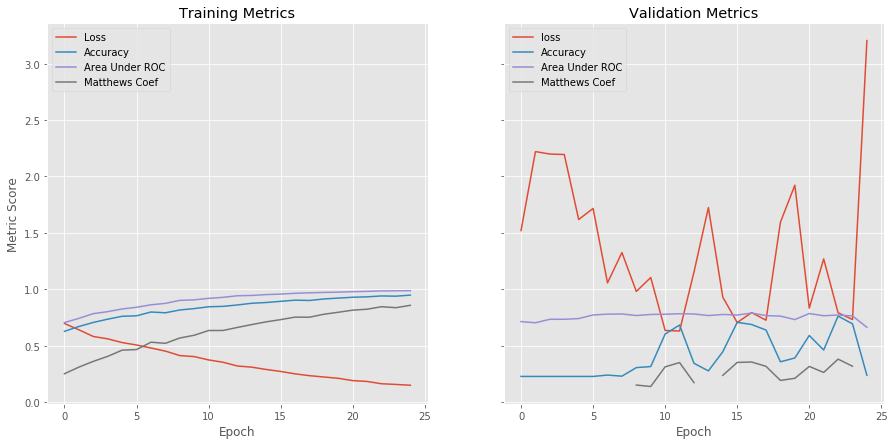

In [27]:
history_plotter(history=conv_history, n_epochs=n_epochs, plot_validation=True)

In [21]:
conv_aug_history = conv_model.fit(
        train_aug_generator, 
        validation_data=vdate_aug_generator,
        callbacks=[cb_aug],
        **fit_params)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 13 steps
Epoch 1/35
52/53 [============================>.] - ETA: 22s - loss: 0.8272 - accuracy: 0.6191 - auc: 0.6740 - matthews_correlation: 0.2175
Epoch 00001: val_matthews_correlation did not improve from -inf
53/53 [==============================] - 1461s 28s/step - loss: 0.8339 - accuracy: 0.6183 - auc: 0.6716 - matthews_correlation: 0.2164 - val_loss: 2.4261 - val_accuracy: 0.2248 - val_auc: 0.5889 - val_matthews_correlation: nan
Epoch 2/35
52/53 [============================>.] - ETA: 1s - loss: 0.7697 - accuracy: 0.6350 - auc: 0.6910 - matthews_correlation: 0.2360
Epoch 00002: val_matthews_correlation did not improve from -inf
53/53 [==============================] - 78s 1s/step - loss: 0.7712 - accuracy: 0.6357 - auc: 0.6906 - matthews_correlation: 0.2375 - val_loss: 3.4530 - val_accuracy: 0.2248 - val_auc: 0.4895 - val_matthews_correlation: nan
Epoch 3/35
52/53 [============================>.] 

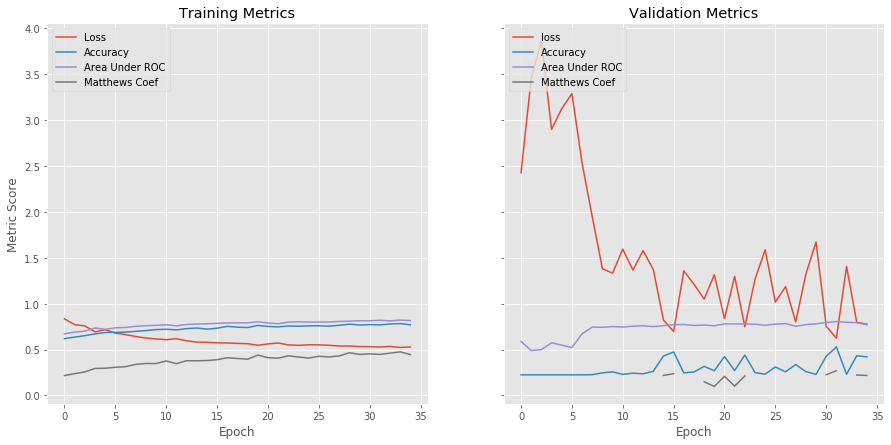

In [22]:
history_plotter(conv_aug_history, n_epochs=n_epochs, plot_validation=True)

# Image Classification via Transfer Learning


In [34]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')
pretrained_mobilenet.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [35]:
mnet_lr = .000_01
mnet_model = tf.keras.models.Sequential()
mnet_model.add(pretrained_mobilenet)
mnet_model.add(tf.keras.layers.GlobalAveragePooling2D())
mnet_model.add(tf.keras.layers.Dense(64))
mnet_model.add(tf.keras.layers.Dropout(.5))
mnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

mnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=mnet_lr),
              loss=loss,
              metrics=METRICS)
mnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
if IN_COLAB:
    save_mnet_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/mnet_classif_weights.hdf5'
    save_xc_path =  r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5'
    save_xc_aug_path =  r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/xc_aug_classif_weights.hdf5'

else:
    save_mnet_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/mnet_classif_weights.hdf5')
    save_xc_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5')
    save_xc_aug_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/xc_aug_classif_weights.hdf5')


cb_mnet = ModelCheckpoint(filepath=save_mnet_path, **checkp_params)
cb_xc = ModelCheckpoint(filepath=save_xc_path, **checkp_params)
cb_aug_xc = ModelCheckpoint(filepath=save_xc_aug_path, **checkp_params)

fgen_params = dict(
                generator=train_generator, 
                steps_per_epoch=int(total_train_samples/batch_size),  
                verbose=1,
                validation_data=vdate_generator,
                validation_steps=int(total_vdate_samples/batch_size),
                class_weight=class_weight,
                use_multiprocessing=True
                )
fgen_aug_params = fgen_params.copy()
fgen_aug_params['generator'] = train_aug_generator

In [0]:
mnet_history = mnet_model.fit_generator(epochs=50,
                                        callbacks=[cb_mnet],
                                        **fgen_params)

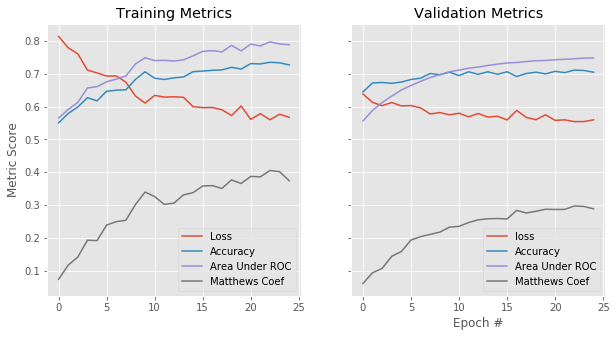

In [0]:
history_plotter(mnet_history)

In [28]:
pretrained_xception = tf.keras.applications.Xception(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')
pretrained_xception.trainable = False

xc_lr = .000_01
xc_model = tf.keras.models.Sequential()
xc_model.add(pretrained_xception)
xc_model.add(tf.keras.layers.GlobalAveragePooling2D())
xc_model.add(tf.keras.layers.Dense(64))
xc_model.add(tf.keras.layers.Dropout(.5))
xc_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

xc_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=xc_lr),
              loss=loss,
              metrics=METRICS)
xc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 20,992,681
Trainable params: 131,201
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
xc_epochs = 25
xc_history = xc_model.fit_generator(epochs=xc_epochs,
                                    callbacks=[cb_xc],
                                    **fgen_params)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 13 steps
Epoch 1/25
52/53 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.5397 - auc: 0.5550 - matthews_correlation: 0.0704WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_matthews_correlation improved from -inf to 0.17437, saving model to /content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5
53/53 [==============================] - 61s 1s/step - loss: 0.6972 - accuracy: 0.5413 - auc: 0.5571 - matthews_correlation: 0.0750 - val_loss: 0.6665 - val_accuracy: 0.7392 - val_auc: 0.6526 - val_matthews_correlation: 0.1744
Epoch 2/25
52/53 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5565 - auc: 0.5822 - matthews_c

In [0]:
history_plotter(xc_history, n_epochs=xc_epochs)

In [0]:
xc_aug_history = xc_model.fit_generator(
    epochs=25,
    callbacks=[cb_aug_xc],
    **fgen_aug_params,
    )

In [0]:
history_plotter(xc_aug_history, n_epochs=25, True)

# Test

In [0]:
save_xc_path = r'C:\Users\User\Documents\GitHub\sidewalks_deep-learning\models\xc_classif_weights.hdf5'
cust={'matthews_correlation': matthews_correlation}
xc_model = load_model(save_xc_path, custom_objects=cust)
test_results = xc_model.evaluate(test_generator)
print("Test results: \nBinary Cross-Entropy: {:.4f}\nAccuracy: \
{:.4f}\nArea Under ROC: {:.4f}\nMatthews Correlation Coefficient: {:.4f}".format(*test_results))